### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper,shrinkBigKTransformer,logminus_T,exp_T,logminplus1_T,none_T, logp1_T

In [2]:
import daal4py.sklearn
daal4py.sklearn.patch_sklearn()

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [3]:
test_share=0.2 
cv_folds=10
cv_reps=10
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=300,
                          n_features=8, # x variables generated and returned 
                          n_informative=2, # x variables included in the actual model of y
                          effective_rank=2, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=3,
                          random_state=rs,
                          bias=1)

#xt=np.product(X[:,0:2],axis=-1)
for i in range(1,5,5):
    sgn_mult=3**i*(-1)**i
    y+=sgn_mult*np.product(10*X[:,i:i+2],axis=-1)
print(y.shape)
#xtnorm=xt/np.sum(xt)
#print(xtnorm.shape)
y=np.exp((y-np.min(y))/10+1)
print(y)


(300,)
[ 5.83828661  8.44695482  9.36319015 11.50135     9.10864527  5.58642772
 14.08775916  9.19131281  5.60071861 18.49871298  7.87098582 13.60203159
  7.18307196  6.11007064 10.08182414 12.37225433 17.63357577  7.83053843
 10.83476776  9.00847165 15.07424402  7.54233842  8.6971847   7.30304316
 12.54804546  5.40169222  5.78248026  8.83998339 10.07656479  7.48670171
 14.46035019  7.16905056  8.31816153  4.80789697 11.76358219  9.42717464
 16.55990966 13.28219764  9.11943743 11.17570153 11.15344997  8.36141122
  6.44707494 10.51484939  4.81741121  9.47307191  6.27427995 14.2460282
  6.72846665  7.37558685  9.74825026 12.17091568  7.59900901 14.8572838
  5.77523281 14.51985474  7.7151082   5.1961547   4.47289817  9.0491113
  7.97297815  7.69821113  7.17733297 10.49790802 21.57148756  3.63343059
  9.25751018 11.70326843  5.3669702   6.16322552  8.43645176  9.71547746
 12.95555322  8.76020801 15.68756419  9.64289995 12.65512861  5.37072772
  7.05508452  9.56440993  9.70673781  8.3285346

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

In [7]:
n,k=X_train.shape

max_k=n//2

vbhelper.max_k=max_k

In [8]:
# use lambda to make a callable object for creating new models, but with args set already
# may be unnecessary due to sklearn cloning


linear_regression=lambda: make_pipeline(StandardScaler(),LinearRegression(fit_intercept=1)) 
linear_regression_lars=lambda: make_pipeline(StandardScaler(),shrinkBigKTransformer(max_k=max_k),LinearRegression()) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html
elastic_net =lambda: make_pipeline(StandardScaler(), ElasticNetCV())
linear_svr =lambda: make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=lambda: make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(GradientBoostingRegressor())

g_pts=3 # grid points for gridsearchcv param_grid 
linear_svr = Pipeline(steps=[('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=10000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,2,g_pts)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=10000, cache_size=2*10**3))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,g_pts),'rbf_svr__gamma':np.logspace(-1,0.5,g_pts)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


In [9]:
transformer_list=[none_T(),logp1_T ()]#[logminplus1_T(),none_T(),logminus_T()]#exp_T()] # imported...
lin_reg_y_t_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=linear_regression_lars()))])
lin_reg_y_t_param_grid={'ttr__transformer':transformer_list}
lin_reg_y_transform=lambda: GridSearchCV(lin_reg_y_t_pipe,param_grid=lin_reg_y_t_param_grid)

#### add PolynomialFeatures() to gridsearch
#### and try shrinking the number of parameters

In [10]:
steps=[
    ('scaler',StandardScaler()),
    ('shrink_k1',shrinkBigKTransformer()), # retain a subset of the best original variables
    ('polyfeat',PolynomialFeatures(interaction_only=1)), # create interactions among them
    ('shrink_k2',shrinkBigKTransformer(selector='elastic-net')), # pick from all of those options
    ('reg',linear_regression())]

inner_params={'polyfeat__degree':[2],
                        'shrink_k1__max_k':np.array(range(2,k,-(-k//4)))} # ceiling divide
inner_cv=RepeatedKFold(n_splits=5, n_repeats=1, random_state=rs)
X_T_pipe=GridSearchCV(Pipeline(steps=steps),param_grid=inner_params,cv=inner_cv)

 

Y_T_X_T_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=X_T_pipe))])
Y_T__param_grid={'ttr__transformer':transformer_list}
lin_reg_Xy_transform=lambda: GridSearchCV(Y_T_X_T_pipe,param_grid=Y_T__param_grid,cv=inner_cv)



In [11]:
estimator_dict={'linear-regression':linear_regression,
                'linear-regression-lars':linear_regression_lars,
                'lin_reg_y_transform':lin_reg_y_transform,
                'lin_reg_Xy_transform':lin_reg_Xy_transform,
                'elastic-net':elastic_net, }
                #'linear-svr-cv':linear_svr_cv, }
                #'rbf-svr-cv':rbf_svr_cv, 
                #'gradient-boosting-reg':gradient_boosting_reg}
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [12]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [13]:
#simple=[est.fit(X_train,y_train) for name,est in model_dict.items()]


In [14]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [15]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [16]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-7.767750932172504
    linear-regression-lars:-7.767750932172504
    lin_reg_y_transform:-7.700657056574722
    lin_reg_Xy_transform:-7.716730636629835
    elastic-net:-7.692453951629908
scores for scorer: neg_mean_absolute_error:
    linear-regression:-2.212949209075363
    linear-regression-lars:-2.212949209075363
    lin_reg_y_transform:-2.1703545836347415
    lin_reg_Xy_transform:-2.1925016442994023
    elastic-net:-2.204739675402468
scores for scorer: r2:
    linear-regression:0.23405927107788022
    linear-regression-lars:0.23405927107788024
    lin_reg_y_transform:0.24570856023058954
    lin_reg_Xy_transform:0.24683343783752967
    elastic-net:0.25003244865374324


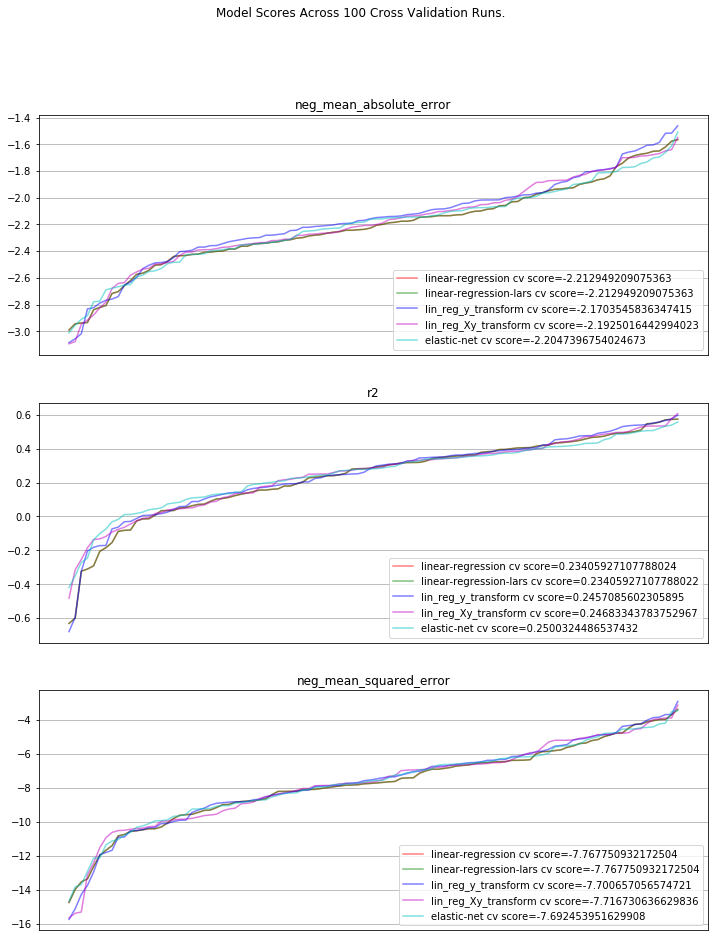

In [17]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [18]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [19]:
final_estimator_name='linear-regression-lars'

In [20]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [21]:
for name in estimator_dict.keys():
    print(name)
    printTestandCVScores(name,cv_score_dict_means)

linear-regression
test set: negative-mse=-8.180034805877858
cv avg: neg_mean_squared_error= -7.767750932172504
cv avg: neg_mean_absolute_error= -2.212949209075363
cv avg: r2= 0.23405927107788022
coefficients:  [ 0.45861607 -0.00244696  0.00292544  0.1044816   0.65681807  0.08927082
  0.14965401  2.22154608]
intercept:  9.162868405865352
linear-regression-lars
test set: negative-mse=-8.180034805877856
cv avg: neg_mean_squared_error= -7.767750932172504
cv avg: neg_mean_absolute_error= -2.212949209075363
cv avg: r2= 0.23405927107788024
coefficients:  [ 0.45861607 -0.00244696  0.00292544  0.1044816   0.65681807  0.08927082
  0.14965401  2.22154608]
intercept:  9.162868405865352
lin_reg_y_transform
test set: negative-mse=-8.162735900998014
cv avg: neg_mean_squared_error= -7.700657056574722
cv avg: neg_mean_absolute_error= -2.1703545836347415
cv avg: r2= 0.24570856023058954
lin_reg_Xy_transform
test set: negative-mse=-7.7377478043466015
cv avg: neg_mean_squared_error= -7.716730636629835
cv a

In [22]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

test set: negative-mse=-7.944420414038822
cv avg: neg_mean_squared_error= -7.692453951629908
cv avg: neg_mean_absolute_error= -2.204739675402468
cv avg: r2= 0.25003244865374324
coefficients:  [ 0.20785946 -0.          0.          0.02343789  0.50946194 -0.
  0.07171553  1.95011755]
intercept:  9.162868405865352


In [23]:
printTestandCVScores('lin_reg_Xy_transform',cv_score_dict_means)

test set: negative-mse=-7.7377478043466015
cv avg: neg_mean_squared_error= -7.716730636629835
cv avg: neg_mean_absolute_error= -2.1925016442994023
cv avg: r2= 0.24683343783752967
